# 패키지 로딩

In [174]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor

from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D, Activation,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add, AveragePooling2D
)

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

# Top 10개 종목에 대한 예측 진행

In [124]:
trade = pd.read_csv('../file/trade_train.csv').iloc[:,1:]
stock = pd.read_csv('../file/stocks.csv')
group3348_top = pd.read_csv('../file/group33-48_stock.csv').iloc[:,1:]

In [125]:
trade.head(5)

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
0,201907,MAD01,288,A000660,Y,Y,7,17,19,234,74800,78500
1,201907,MAD01,288,A001820,Y,Y,3,4,533,154,47385,46700
2,201907,MAD01,288,A004020,Y,Y,3,3,409,528,41411,40000
3,201907,MAD01,288,A005380,Y,Y,4,3,323,451,140602,140628
4,201907,MAD01,288,A005930,Y,Y,13,19,34,101,45350,46850


In [126]:
stock.head(5)

,index,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위
0,0,20190701,A000020,동화약품,N,코스피,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,9680,9840,9680,9710,31341,30581
1,1,20190701,A000080,하이트진로,N,코스피,제조업,음료 제조업,알코올음료 제조업,20550,20550,20200,20300,127186,258535
2,2,20190701,A000100,유한양행,Y,코스피,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,259000,267500,250000,251500,395757,10139357
3,3,20190701,A000120,CJ대한통운,N,코스피,운수 및 창고업,육상운송 및 파이프라인 운송업,도로 화물 운송업,136500,137000,133000,136000,62513,846100
4,4,20190701,A000140,하이트진로홀딩스,Y,코스피,금융 및 보험업,금융업,기타 금융업,9060,9190,8910,9000,7661,6896


In [127]:
group3348_top

,MAD33,MAD34,MAD35,MAD36,MAD37,MAD38,MAD39,MAD40,MAD41,MAD42,MAD43,MAD44,MAD45,MAD46,MAD47,MAD48
0,A005930,A017670,A005930,A005930,A005930,A005930,A015760,A034730,A019170,A019170,A005930,A005930,A035720,A005930,A005930,A035420
1,A000660,A030200,A003490,A096530,A035720,A035720,A003490,A035420,A003000,A065450,A035720,A005935,A005930,A035720,A017670,A035720
2,A003490,A035720,A000660,A000660,A035420,A035420,A000720,A005930,A007570,A003000,A035420,A105560,A055550,A105560,A005935,A051910
3,A042670,A035420,A005380,A005935,A068760,A000660,A005380,A035720,A065450,A007570,A005935,A000660,A035420,A000660,A035720,A005930
4,A005935,A005930,A035720,A205470,A065450,A096530,A064350,A068760,A068760,A068760,A000660,A055550,A034730,A035420,A030200,A034730
5,A020560,A005380,A035420,A336260,A068270,A068760,A010140,A068270,A005690,A068270,A005380,A006800,A005380,A005935,A035420,A105560
6,A336260,A015760,A010140,A058820,A096530,A005935,A034020,A010140,A068270,A096530,A006400,A034730,A105560,A055550,A005380,A005380
7,A000720,A000660,A005935,A065450,A010140,A068270,A042670,A105560,A096530,A008350,A010140,A035720,A006800,A005380,A000660,A005490
8,A010140,A008770,A000720,A068760,A007570,A010140,A000270,A000660,A205470,A298380,A008770,A086790,A008770,A034730,A105560,A006800
9,A034220,A000270,A008770,A010140,A086900,A065450,A005930,A006800,A011000,A005690,A068270,A005380,A051910,A006800,A006400,A008770


#### 기준년월 데이터 프레임 만들어서 merge로 합치기(Nan는 0 처리)

In [164]:
for i in range(len(group3348_top.columns)):
    id_group = trade['그룹번호'] == group3348_top.columns[i]
    globals()['MAD{}'.format(i+33)] = trade[id_group]

In [165]:
standard = pd.DataFrame({'기준년월':list(range(201907,201913)) + list(range(202001,202007))})

In [172]:
for j in range(len(group3348_top)):
    group_stock = MAD33['종목번호'] == group3348_top['MAD33'][j]
    globals()['MAD33_filter{}'.format(j)] = pd.merge(standard, MAD33[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD34['종목번호'] == group3348_top['MAD34'][j]
    globals()['MAD34_filter{}'.format(j)] = pd.merge(standard, MAD34[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD35['종목번호'] == group3348_top['MAD35'][j]
    globals()['MAD35_filter{}'.format(j)] = pd.merge(standard, MAD35[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD36['종목번호'] == group3348_top['MAD36'][j]
    globals()['MAD36_filter{}'.format(j)] = pd.merge(standard, MAD36[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD37['종목번호'] == group3348_top['MAD37'][j]
    globals()['MAD37_filter{}'.format(j)] = pd.merge(standard, MAD37[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD38['종목번호'] == group3348_top['MAD38'][j]
    globals()['MAD38_filter{}'.format(j)] = pd.merge(standard, MAD38[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD40['종목번호'] == group3348_top['MAD40'][j]
    globals()['MAD40_filter{}'.format(j)] = pd.merge(standard, MAD40[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD41['종목번호'] == group3348_top['MAD41'][j]
    globals()['MAD41_filter{}'.format(j)] = pd.merge(standard, MAD41[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD42['종목번호'] == group3348_top['MAD42'][j]
    globals()['MAD42_filter{}'.format(j)] = pd.merge(standard, MAD42[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD43['종목번호'] == group3348_top['MAD43'][j]
    globals()['MAD43_filter{}'.format(j)] = pd.merge(standard, MAD43[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD44['종목번호'] == group3348_top['MAD44'][j]
    globals()['MAD44_filter{}'.format(j)] = pd.merge(standard, MAD44[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD45['종목번호'] == group3348_top['MAD45'][j]
    globals()['MAD45_filter{}'.format(j)] = pd.merge(standard, MAD45[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD46['종목번호'] == group3348_top['MAD46'][j]
    globals()['MAD46_filter{}'.format(j)] = pd.merge(standard, MAD46[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD47['종목번호'] == group3348_top['MAD47'][j]
    globals()['MAD47_filter{}'.format(j)] = pd.merge(standard, MAD47[group_stock], how='left').fillna(0)
    
    group_stock = None
    group_stock = MAD48['종목번호'] == group3348_top['MAD48'][j]
    globals()['MAD48_filter{}'.format(j)] = pd.merge(standard, MAD48[group_stock], how='left').fillna(0)

### 데이터 확인해보기

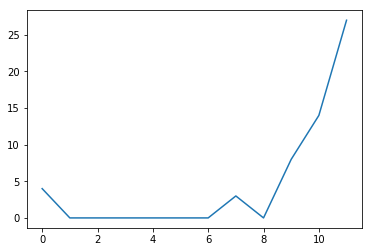

In [173]:
plt.plot(MAD48_filter0['매도고객수'])

In [205]:
MAD48_filter0

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
0,201907,MAD48,163.0,A035420,N,Y,0.0,4.0,0.0,110.0,-1.0,118500.0
1,201908,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,201909,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,201910,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,201911,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,201912,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
6,202001,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
7,202002,MAD48,163.0,A035420,Y,Y,4.0,3.0,43.0,55.0,183000.0,184500.0
8,202003,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
9,202004,MAD48,163.0,A035420,Y,Y,7.0,8.0,44.0,48.0,189000.0,190500.0


### 전역 변수 목록 가져와서 key 값 저장

In [203]:
global_var = list(globals().keys())
variable_list = list()

for idx, word in enumerate(global_var):
    if global_var[idx].startswith('MAD') == True and len(global_var[idx]) >= 6:
        variable_list.append(global_var[idx])

variable_list.sort()

In [204]:
variable_list

['MAD33_filter0',
 'MAD33_filter1',
 'MAD33_filter2',
 'MAD33_filter3',
 'MAD33_filter4',
 'MAD33_filter5',
 'MAD33_filter6',
 'MAD33_filter7',
 'MAD33_filter8',
 'MAD33_filter9',
 'MAD34_filter0',
 'MAD34_filter1',
 'MAD34_filter2',
 'MAD34_filter3',
 'MAD34_filter4',
 'MAD34_filter5',
 'MAD34_filter6',
 'MAD34_filter7',
 'MAD34_filter8',
 'MAD34_filter9',
 'MAD35_filter0',
 'MAD35_filter1',
 'MAD35_filter2',
 'MAD35_filter3',
 'MAD35_filter4',
 'MAD35_filter5',
 'MAD35_filter6',
 'MAD35_filter7',
 'MAD35_filter8',
 'MAD35_filter9',
 'MAD36_filter0',
 'MAD36_filter1',
 'MAD36_filter2',
 'MAD36_filter3',
 'MAD36_filter4',
 'MAD36_filter5',
 'MAD36_filter6',
 'MAD36_filter7',
 'MAD36_filter8',
 'MAD36_filter9',
 'MAD37_filter0',
 'MAD37_filter1',
 'MAD37_filter2',
 'MAD37_filter3',
 'MAD37_filter4',
 'MAD37_filter5',
 'MAD37_filter6',
 'MAD37_filter7',
 'MAD37_filter8',
 'MAD37_filter9',
 'MAD38_filter0',
 'MAD38_filter1',
 'MAD38_filter2',
 'MAD38_filter3',
 'MAD38_filter4',
 'MAD38_fi

### 시계열 모델 구축

In [242]:
from statsmodels.tsa.arima_model import ARIMA

order = (1, 0, 0)
for i in range(len(variable_list)):
    model = ARIMA(globals()[variable_list[i]].iloc[:,6], order)
    globals()['fit_{}'.format(i)] = model.fit(trend='nc',full_output=True, disp=1)

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\user\

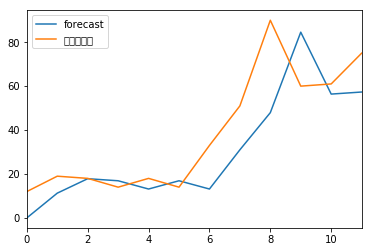

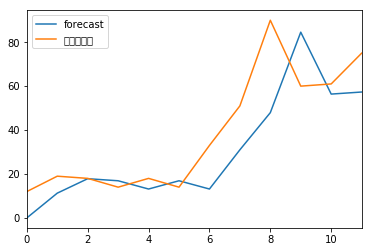

In [243]:
fit_0.plot_predict()

In [246]:
for i in range(len(variable_list)):
    globals()['fore_{}'.format(i)] = globals()['fit_{}'.format(i)].forecast(steps=1)
    if i % 10 == 0:
        print('-------------------')
    print(globals()['fore_{}'.format(i)][0])
    

-------------------
70.47538811579003
39.54062426245311
28.99119755534975
25.935963380510046
23.774893102288786
19.258185826274776
14.281767665316718
12.86288793946593
-2.4561812675303436e-06
14.294921445780318
-------------------
17.999999957831548
16.999999939145226
16.99999992754116
14.270936406981248
10.537166868572175
8.86264119490649
9.538016612128782
4.450592656920717
-1.5806357199242825e-07
5.414273544035975e-07
-------------------
163.8211259375184
85.3922962257782
84.1152156461729
78.25801990415255
76.55436329160055
53.32859566820382
51.12377969102176
42.312204336727746
37.70121378242441
34.0224887922459
-------------------
42.69241648333647
19.62118947432704
21.999999999999385
16.9511830476446
12.934018732923363
11.772837457932908
11.318592549986047
11.999999999990289
11.999999841820618
7.376867189496106e-07
-------------------
36.193091167408
39.78744861651393
38.117936228833116
22.712311797268057
18.927386163025982
18.424462126419204
14.662499570015077
12.93787477136241
1.

# MAD40 그룹과 MAD41 그룹만 3등과 4등의 위치가 바뀌고 나머지는 변화 X

In [5]:
train_x = data.iloc[0:25285,4:]
train_y = data.iloc[0:25285,3]
val_x = data.iloc[25285:,4:]
val_y = data.iloc[25285:,3]

In [6]:
train_x = train_x.values.reshape(-1,5)
train_y = train_y.values.reshape(-1,1)
val_x = val_x.values.reshape(-1,5)
val_y = val_y.values.reshape(-1,1)

In [7]:
train_x.shape

(25285, 5)

In [8]:
input_layer = Input(shape = train_x.shape[1:])
x = Dense(256, activation='relu')(input_layer)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(1000, activation='sigmoid')(x)

model = Model(input_layer, output_layer)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              513000    
Total params: 974,568
Trainable params: 974,568
Non-trainable params: 

In [9]:
model.compile(loss='mean_squared_error',optimizer='Adam')

Instructions for updating:
Use tf.cast instead.


In [10]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.97 ** x)

hist = model.fit(train_x, train_y, epochs=5, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
25285/25285 [==============================] - 40s 2ms/sample - loss: 311.3847
Epoch 2/5
25285/25285 [==============================] - 40s 2ms/sample - loss: 311.2245
Epoch 3/5
25285/25285 [==============================] - 40s 2ms/sample - loss: 311.19811s -
Epoch 4/5
25285/25285 [==============================] - 41s 2ms/sample - loss: 311.1897
Epoch 5/5
25285/25285 [==============================] - 37s 1ms/sample - loss: 311.1714


In [ ]:
# test 데이터셋을 그룹별 - 종목별 나눠서 넣어보면 답이 나옴

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)